# 🎵 Audio Features Database Inspector

This notebook helps you monitor and analyze audio features being recorded by the speech processing pipeline.

## What you'll see:
- Database statistics and health
- Recent conversations with audio features
- Audio feature analysis and visualization
- Speaker detection insights

In [1]:
# Setup and imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Add current directory to path
sys.path.insert(0, os.path.abspath('.'))

# Import our database
from utils.enhanced_conversation_db import EnhancedConversationDB

# Initialize database
db = EnhancedConversationDB()

print("✅ Database initialized successfully!")
# Try to get database location - different ChromaDB versions have different attributes
try:
    if hasattr(db.client, '_settings'):
        db_location = db.client._settings.persist_directory
    elif hasattr(db.client, '_system'):
        db_location = getattr(db.client._system, 'persist_directory', 'Unknown')
    else:
        db_location = "Default location (data/vector_db)"
    print(f"📂 Database location: {db_location}")
except:
    print("📂 Database location: Default location (data/vector_db)")

✅ Database initialized successfully!
📂 Database location: Unknown


In [2]:
stats = db.get_conversation_stats()
print(f"Stats: {stats}")


Stats: {'total_conversations': 7, 'total_audio_features': 4, 'conversations_with_audio': 4}


## 📊 Database Overview

🔍 DATABASE OVERVIEW
📝 Total Conversations: 16
🎵 Total Audio Features: 9
🔗 Conversations with Audio: 9
📈 Audio Coverage: 56.2%


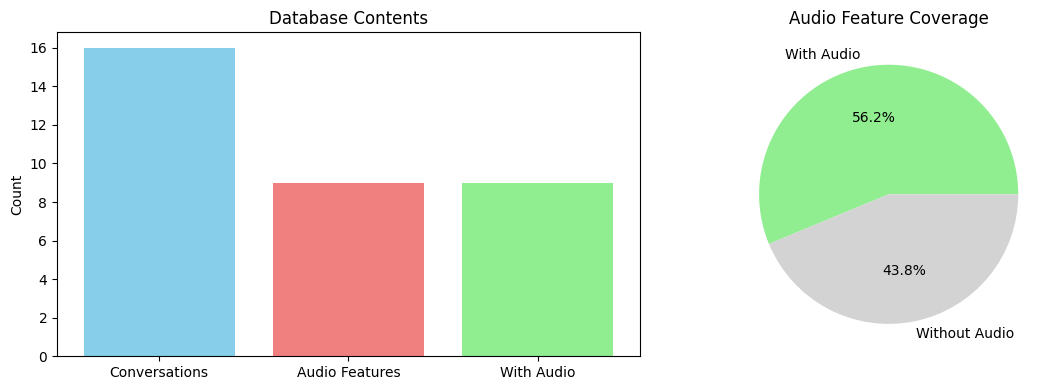

In [12]:
# Get overall database statistics
stats = db.get_conversation_stats()

print("🔍 DATABASE OVERVIEW")
print("=" * 40)
print(f"📝 Total Conversations: {stats['total_conversations']}")
print(f"🎵 Total Audio Features: {stats['total_audio_features']}")
print(f"🔗 Conversations with Audio: {stats['conversations_with_audio']}")
print(f"📈 Audio Coverage: {stats['conversations_with_audio']/max(stats['total_conversations'], 1)*100:.1f}%")

# Visual representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of counts
categories = ['Conversations', 'Audio Features', 'With Audio']
counts = [stats['total_conversations'], stats['total_audio_features'], stats['conversations_with_audio']]
ax1.bar(categories, counts, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Database Contents')
ax1.set_ylabel('Count')

# Pie chart of coverage
with_audio = stats['conversations_with_audio']
without_audio = stats['total_conversations'] - with_audio
if stats['total_conversations'] > 0:
    ax2.pie([with_audio, without_audio], labels=['With Audio', 'Without Audio'], 
            autopct='%1.1f%%', colors=['lightgreen', 'lightgray'])
    ax2.set_title('Audio Feature Coverage')
else:
    ax2.text(0.5, 0.5, 'No data yet', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Audio Feature Coverage')

plt.tight_layout()
plt.show()

## 📋 Recent Conversations

In [8]:
# Get recent conversations
conv_data = db.conversations.get(limit=50)

if conv_data['documents']:
    # Create DataFrame for easier analysis
    conversations_df = pd.DataFrame({
        'id': conv_data['ids'],
        'text': conv_data['documents'],
        'speaker': [m.get('speaker', 'Unknown') for m in conv_data['metadatas']],
        'role': [m.get('role', 'unknown') for m in conv_data['metadatas']],
        'session_id': [m.get('session_id', 'unknown') for m in conv_data['metadatas']],
        'timestamp': [m.get('timestamp', '') for m in conv_data['metadatas']],
        'has_audio': [m.get('has_audio_features', False) for m in conv_data['metadatas']],
        'feedback': [m.get('feedback_helpful', '') for m in conv_data['metadatas']]
    })
    
    # Convert timestamp to datetime
    conversations_df['datetime'] = pd.to_datetime(conversations_df['timestamp'], errors='coerce')
    
    print(f"📝 Showing {len(conversations_df)} recent conversations")
    print("\n🕐 RECENT CONVERSATIONS (Last 10)")
    print("=" * 60)
    
    # Show last 10 conversations
    recent = conversations_df.sort_values('datetime', ascending=False).head(10)
    
    for idx, row in recent.iterrows():
        audio_icon = "🎵" if row['has_audio'] else "📝"
        time_str = row['datetime'].strftime('%H:%M:%S') if pd.notna(row['datetime']) else 'Unknown'
        text_preview = row['text'][:60] + "..." if len(row['text']) > 60 else row['text']
        print(f"{audio_icon} {time_str} | {row['speaker']} ({row['role']}): {text_preview}")
        
    # Display as table
    display_cols = ['datetime', 'speaker', 'role', 'has_audio', 'text']
    display_df = recent[display_cols].copy()
    display_df['text'] = display_df['text'].str[:50] + '...'
    display_df
else:
    print("📭 No conversations found in database yet.")
    print("💡 Run the main pipeline (python main.py) and have some conversations!")

📝 Showing 7 recent conversations

🕐 RECENT CONVERSATIONS (Last 10)
🎵 13:42:10 | Speaker F (user): Speaker F (user): alright goodbye [GEMMA]
📝 13:42:05 | Gemma (assistant): Gemma (assistant): That's so kind of you to say! Thank you. ...
🎵 13:42:04 | Speaker W (user): Speaker W (user): i'm glad to hear that you're ok [GEMMA]
📝 13:41:59 | Gemma (assistant): Gemma (assistant): That's wonderful to hear! I'm glad you're...
🎵 13:41:58 | Speaker P (user): Speaker P (user): i'm really thinking that things are great ...
📝 13:41:47 | Gemma (assistant): Gemma (assistant): I am doing well, thank you for asking! 😊 ...
🎵 13:41:44 | Speaker V (user): Speaker V (user): how are you [GEMMA]


## 🎵 Audio Features Analysis

In [6]:
# Get audio features data
features_list, metadata_list = db.get_audio_features_for_clustering()

if features_list:
    print(f"🎵 Found {len(features_list)} audio feature records")
    
    # Create DataFrame for audio features
    audio_df = pd.DataFrame({
        'conversation_id': [m.get('conversation_id', '') for m in metadata_list],
        'session_id': [m.get('session_id', '') for m in metadata_list],
        'speaker': [m.get('speaker', 'Unknown') for m in metadata_list],
        'timestamp': [m.get('timestamp', '') for m in metadata_list],
        'features': features_list
    })
    
    # Extract individual features (assuming [energy, rms_energy])
    audio_df['energy'] = [f[0] if len(f) > 0 else 0 for f in features_list]
    audio_df['rms_energy'] = [f[1] if len(f) > 1 else 0 for f in features_list]
    
    # Convert timestamp
    audio_df['datetime'] = pd.to_datetime(audio_df['timestamp'], errors='coerce')
    
    print("\n📊 AUDIO FEATURES SUMMARY")
    print("=" * 40)
    print(f"Energy - Min: {audio_df['energy'].min():.1f}, Max: {audio_df['energy'].max():.1f}, Mean: {audio_df['energy'].mean():.1f}")
    print(f"RMS Energy - Min: {audio_df['rms_energy'].min():.1f}, Max: {audio_df['rms_energy'].max():.1f}, Mean: {audio_df['rms_energy'].mean():.1f}")
    
    # Show recent audio features
    print("\n🎵 RECENT AUDIO FEATURES (Last 10)")
    print("=" * 50)
    recent_audio = audio_df.sort_values('datetime', ascending=False).head(10)
    
    for idx, row in recent_audio.iterrows():
        time_str = row['datetime'].strftime('%H:%M:%S') if pd.notna(row['datetime']) else 'Unknown'
        print(f"🎵 {time_str} | {row['speaker']} | Energy: {row['energy']:.1f}, RMS: {row['rms_energy']:.1f}")
    
    display(audio_df[['datetime', 'speaker', 'energy', 'rms_energy']].head(10))
    
else:
    print("🎵 No audio features found in database yet.")
    print("💡 Make sure you're speaking during conversations so audio features get recorded!")

🎵 Found 9 audio feature records

📊 AUDIO FEATURES SUMMARY
Energy - Min: 10.9, Max: 108.3, Mean: 39.4
RMS Energy - Min: 13.6, Max: 59.9, Mean: 34.5

🎵 RECENT AUDIO FEATURES (Last 10)
🎵 13:23:11 | Speaker L | Energy: 19.0, RMS: 22.9
🎵 13:23:01 | Speaker H | Energy: 34.0, RMS: 43.1
🎵 13:22:53 | Speaker Y | Energy: 73.5, RMS: 40.2
🎵 13:22:45 | Speaker T | Energy: 42.9, RMS: 48.7
🎵 13:22:37 | Speaker K | Energy: 14.9, RMS: 19.5
🎵 13:22:25 | Speaker R | Energy: 108.3, RMS: 59.9
🎵 13:22:04 | Speaker D | Energy: 30.1, RMS: 36.1
🎵 13:21:43 | Speaker Q | Energy: 20.8, RMS: 26.9
🎵 13:21:35 | Speaker O | Energy: 10.9, RMS: 13.6


,datetime,speaker,energy,rms_energy
0,2025-08-04 13:21:35.169464,Speaker O,10.925781,13.611303
1,2025-08-04 13:21:43.610348,Speaker Q,20.845703,26.894851
2,2025-08-04 13:22:04.086620,Speaker D,30.130371,36.108932
3,2025-08-04 13:22:25.701346,Speaker R,108.329102,59.894610
4,2025-08-04 13:22:37.805246,Speaker K,14.931641,19.505533
5,2025-08-04 13:22:45.873189,Speaker T,42.861816,48.734989
6,2025-08-04 13:22:53.698878,Speaker Y,73.505371,40.180398
7,2025-08-04 13:23:01.107143,Speaker H,33.972168,43.082854
8,2025-08-04 13:23:11.729370,Speaker L,19.046875,22.884646


## 📈 Audio Features Visualization

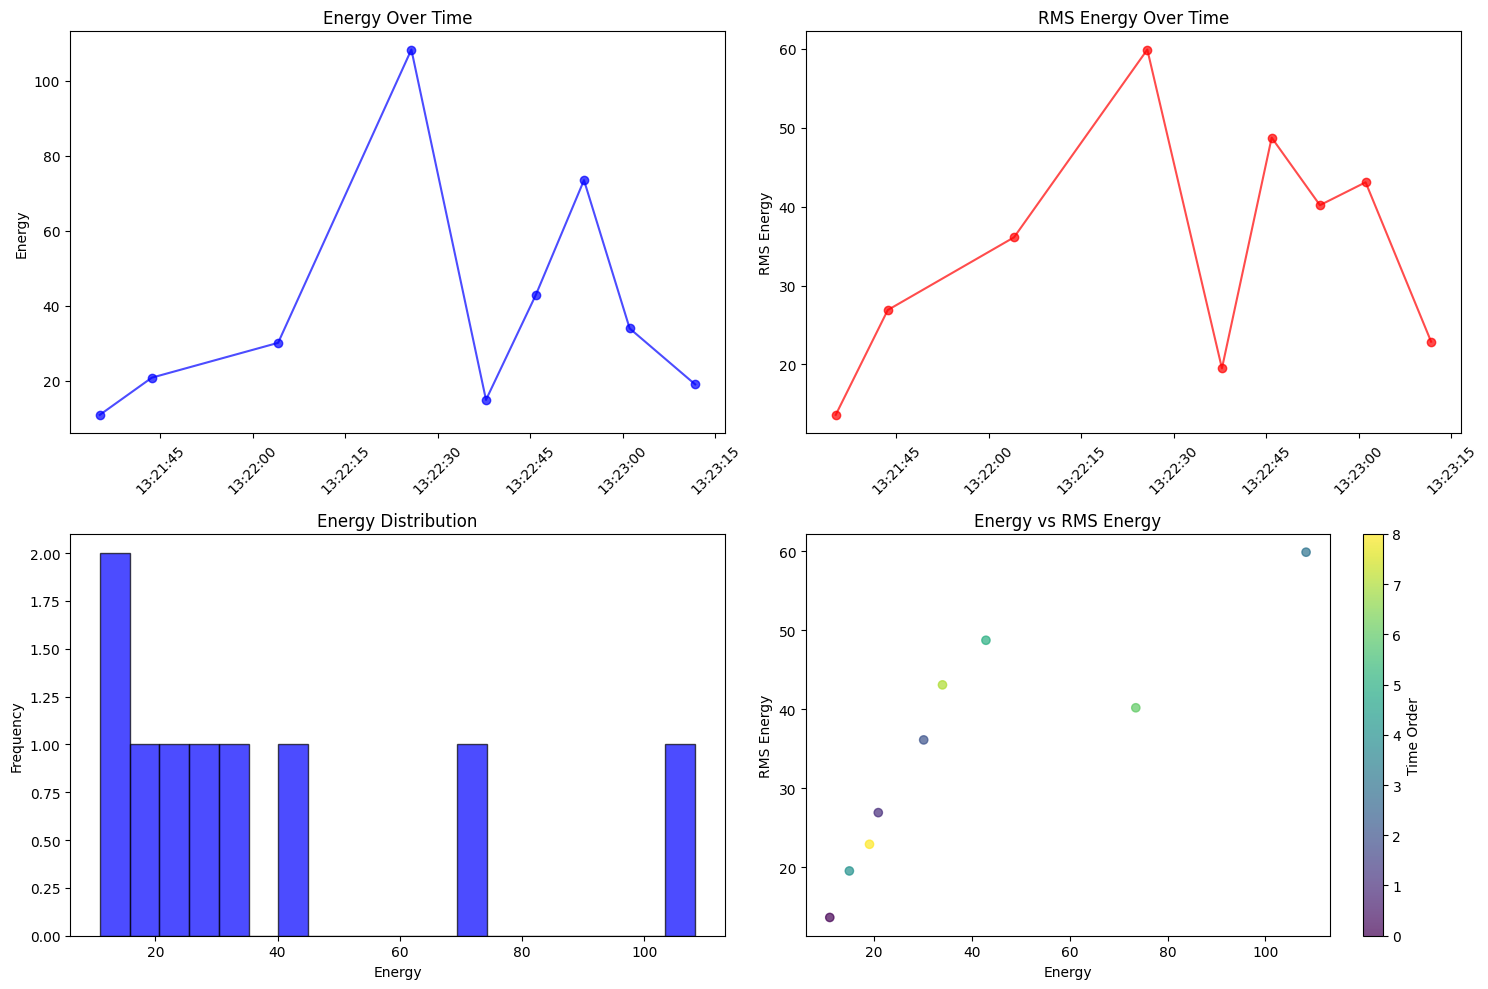

In [7]:
if features_list and len(features_list) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Energy over time
    if len(audio_df[audio_df['datetime'].notna()]) > 0:
        time_sorted = audio_df[audio_df['datetime'].notna()].sort_values('datetime')
        axes[0,0].plot(time_sorted['datetime'], time_sorted['energy'], 'b-o', alpha=0.7)
        axes[0,0].set_title('Energy Over Time')
        axes[0,0].set_ylabel('Energy')
        axes[0,0].tick_params(axis='x', rotation=45)
    else:
        axes[0,0].text(0.5, 0.5, 'No timestamp data', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Energy Over Time')
    
    # 2. RMS Energy over time
    if len(audio_df[audio_df['datetime'].notna()]) > 0:
        axes[0,1].plot(time_sorted['datetime'], time_sorted['rms_energy'], 'r-o', alpha=0.7)
        axes[0,1].set_title('RMS Energy Over Time')
        axes[0,1].set_ylabel('RMS Energy')
        axes[0,1].tick_params(axis='x', rotation=45)
    else:
        axes[0,1].text(0.5, 0.5, 'No timestamp data', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('RMS Energy Over Time')
    
    # 3. Energy distribution
    axes[1,0].hist(audio_df['energy'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[1,0].set_title('Energy Distribution')
    axes[1,0].set_xlabel('Energy')
    axes[1,0].set_ylabel('Frequency')
    
    # 4. Energy vs RMS Energy scatter
    scatter = axes[1,1].scatter(audio_df['energy'], audio_df['rms_energy'], 
                              c=range(len(audio_df)), cmap='viridis', alpha=0.7)
    axes[1,1].set_title('Energy vs RMS Energy')
    axes[1,1].set_xlabel('Energy')
    axes[1,1].set_ylabel('RMS Energy')
    plt.colorbar(scatter, ax=axes[1,1], label='Time Order')
    
    plt.tight_layout()
    plt.show()
    
elif features_list:
    print("📊 Only one audio feature record found. Need more data for visualization.")
else:
    print("📊 No audio features available for visualization yet.")

## 👥 Speaker Analysis

👥 SPEAKER ANALYSIS

🎤 Speaker O:
  📊 1 audio samples
  🔊 Energy: 10.9 ± nan
  🎵 RMS: 13.6 ± nan

🎤 Speaker Q:
  📊 1 audio samples
  🔊 Energy: 20.8 ± nan
  🎵 RMS: 26.9 ± nan

🎤 Speaker D:
  📊 1 audio samples
  🔊 Energy: 30.1 ± nan
  🎵 RMS: 36.1 ± nan

🎤 Speaker R:
  📊 1 audio samples
  🔊 Energy: 108.3 ± nan
  🎵 RMS: 59.9 ± nan

🎤 Speaker K:
  📊 1 audio samples
  🔊 Energy: 14.9 ± nan
  🎵 RMS: 19.5 ± nan

🎤 Speaker T:
  📊 1 audio samples
  🔊 Energy: 42.9 ± nan
  🎵 RMS: 48.7 ± nan

🎤 Speaker Y:
  📊 1 audio samples
  🔊 Energy: 73.5 ± nan
  🎵 RMS: 40.2 ± nan

🎤 Speaker H:
  📊 1 audio samples
  🔊 Energy: 34.0 ± nan
  🎵 RMS: 43.1 ± nan

🎤 Speaker L:
  📊 1 audio samples
  🔊 Energy: 19.0 ± nan
  🎵 RMS: 22.9 ± nan


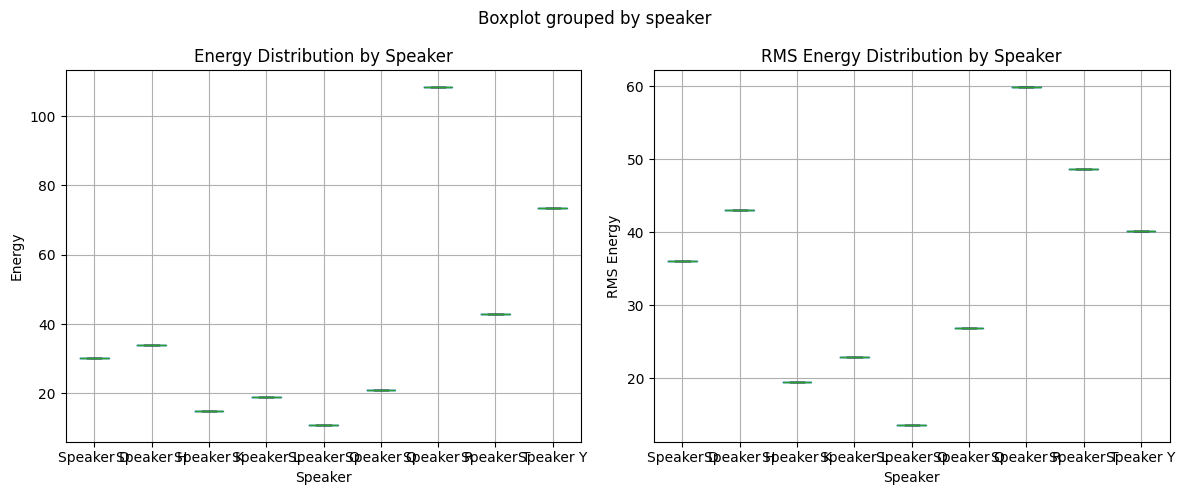

In [8]:
if features_list:
    # Analyze speakers and their audio characteristics
    speaker_stats = audio_df.groupby('speaker').agg({
        'energy': ['count', 'mean', 'std', 'min', 'max'],
        'rms_energy': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("👥 SPEAKER ANALYSIS")
    print("=" * 40)
    
    for speaker in audio_df['speaker'].unique():
        speaker_data = audio_df[audio_df['speaker'] == speaker]
        print(f"\n🎤 {speaker}:")
        print(f"  📊 {len(speaker_data)} audio samples")
        print(f"  🔊 Energy: {speaker_data['energy'].mean():.1f} ± {speaker_data['energy'].std():.1f}")
        print(f"  🎵 RMS: {speaker_data['rms_energy'].mean():.1f} ± {speaker_data['rms_energy'].std():.1f}")
    
    # Speaker comparison visualization
    if len(audio_df['speaker'].unique()) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Box plot of energy by speaker
        audio_df.boxplot(column='energy', by='speaker', ax=ax1)
        ax1.set_title('Energy Distribution by Speaker')
        ax1.set_xlabel('Speaker')
        ax1.set_ylabel('Energy')
        
        # Box plot of RMS energy by speaker
        audio_df.boxplot(column='rms_energy', by='speaker', ax=ax2)
        ax2.set_title('RMS Energy Distribution by Speaker')
        ax2.set_xlabel('Speaker')
        ax2.set_ylabel('RMS Energy')
        
        plt.tight_layout()
        plt.show()
    
else:
    print("👥 No speaker data available yet.")

## 🔄 Real-time Monitoring

Run this cell to continuously monitor new audio features being added to the database:

In [ ]:
import time
from IPython.display import clear_output

def monitor_database(duration_minutes=5):
    """Monitor database for new entries"""
    print(f"🔄 Monitoring database for {duration_minutes} minutes...")
    print("💡 Run your main pipeline (python main.py) in another terminal!")
    print("Press Ctrl+C to stop monitoring\n")
    
    start_time = time.time()
    last_count = 0
    
    try:
        while time.time() - start_time < duration_minutes * 60:
            # Get current stats
            current_stats = db.get_conversation_stats()
            current_count = current_stats['total_audio_features']
            
            # Check for new entries
            if current_count != last_count:
                new_entries = current_count - last_count
                timestamp = datetime.now().strftime('%H:%M:%S')
                print(f"🆕 {timestamp}: +{new_entries} new audio features! (Total: {current_count})")
                
                # Show latest entry details
                features_list, metadata_list = db.get_audio_features_for_clustering()
                if features_list:
                    latest = features_list[-1]
                    latest_meta = metadata_list[-1]
                    print(f"   🎵 Latest: Speaker={latest_meta.get('speaker', 'Unknown')}, "
                          f"Energy={latest[0]:.1f}, RMS={latest[1]:.1f}")
                
                last_count = current_count
            
            time.sleep(2)  # Check every 2 seconds
            
    except KeyboardInterrupt:
        print("\n⏹️ Monitoring stopped by user")
    
    print(f"\n✅ Monitoring complete. Final count: {last_count} audio features")

# Uncomment the line below to start monitoring
# monitor_database(duration_minutes=5)

## 🧹 Database Maintenance

In [ ]:
# Database health check
print("🔍 DATABASE HEALTH CHECK")
print("=" * 30)

# Check collections exist
try:
    conv_count = db.conversations.count()
    audio_count = db.audio_features.count()
    print(f"✅ Conversations collection: {conv_count} records")
    print(f"✅ Audio features collection: {audio_count} records")
except Exception as e:
    print(f"❌ Database error: {e}")

# Check for orphaned audio features (audio without corresponding conversation)
if 'features_list' in locals() and 'conv_data' in locals() and features_list and conv_data['documents']:
    conv_ids = set(conv_data['ids'])
    audio_conv_ids = set(m.get('conversation_id', '') for m in metadata_list)
    
    orphaned = audio_conv_ids - conv_ids
    if orphaned:
        print(f"⚠️  Found {len(orphaned)} orphaned audio features")
    else:
        print("✅ No orphaned audio features found")

# Show database size
try:
    import os
    # Try different ways to get database path
    db_path = None
    if hasattr(db.client, '_settings'):
        db_path = db.client._settings.persist_directory
    elif hasattr(db.client, '_system'):
        db_path = getattr(db.client._system, 'persist_directory', None)
    
    if db_path and os.path.exists(db_path):
        total_size = sum(os.path.getsize(os.path.join(dirpath, filename))
                        for dirpath, dirnames, filenames in os.walk(db_path)
                        for filename in filenames)
        size_mb = total_size / (1024 * 1024)
        print(f"💾 Database size: {size_mb:.2f} MB")
    else:
        print("💾 Database size: Could not determine (using default location)")
except Exception as e:
    print(f"❓ Could not determine database size: {e}")

print("\n✅ Health check complete!")

## 📝 Quick Commands

Here are some quick commands you can run to check specific things:

In [ ]:
# Quick stats refresh
def refresh_stats():
    stats = db.get_conversation_stats()
    print(f"📊 Current Stats: {stats['total_conversations']} conversations, "
          f"{stats['total_audio_features']} audio features, "
          f"{stats['conversations_with_audio']} with audio")
    return stats

# Show latest entries
def show_latest(n=5):
    features_list, metadata_list = db.get_audio_features_for_clustering()
    if features_list:
        print(f"🎵 Latest {min(n, len(features_list))} audio features:")
        for i in range(min(n, len(features_list))):
            idx = -(i+1)
            features = features_list[idx]
            meta = metadata_list[idx]
            print(f"  {i+1}. {meta.get('speaker', 'Unknown')}: Energy={features[0]:.1f}, RMS={features[1]:.1f}")
    else:
        print("🎵 No audio features found")

print("💡 Available functions:")
print("  - refresh_stats() - Get current database statistics")
print("  - show_latest(n) - Show latest n audio features")
print("\nExample usage:")
print("  refresh_stats()")
print("  show_latest(10)")